In [1]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('../..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")
sys.path.append(module_path+"/experiments")

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [3]:
from datasets import train_test_random_split, load_dsprites, CustomDSpritesDatasetFactorVAE
from train import train_beta_vae, test_beta_vae, test_control_vae
from loss import loss_beta_vae, compute_reconstruction_loss
from beta_vae import BetaVAEDSprites, Classifier
from utils import latent_transversal, load_checkpoint, save_checkpoint
from entanglement_metric import entanglement_metric_factor_vae, entanglement_metric_beta_vae

In [4]:
whole_dataset = load_dsprites("../../datasets/dsprites.npz", False)
dataset = whole_dataset['imgs']
dataset = torch.from_numpy(dataset)

In [5]:
#np.random.seed(2)
#torch.manual_seed(2)
#random.seed(2)

In [6]:
def plot_all_transversals(model, original):
    fig = plt.figure(figsize=[12, 12])
    for i in range(10):
        imgs = latent_transversal(model, original, -3, 3, 10, i)
        for j, img in enumerate(imgs):
            plt.subplot(10, 10, i * 10 + j + 1)
            plt.axis('off')
            plt.imshow(torch.sigmoid(img.detach()).view(64,64), cmap='Greys_r')
    plt.show()

In [7]:
def compute_latent_gaussian_variance(model, dataset, factorvae=False):
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    accumulator = torch.zeros(10)
    with torch.no_grad():
        for index, data in enumerate(loader):
            # shape of data is 64 x img_size
            if factorvae:
                _, _, logvar, _ = model(data.float())
            else:
                _, _, logvar = model(data.float())
            accumulator = accumulator + logvar.div(2).exp().sum(0)
            if index % 1000 == 999:
                print('.', end='')
            del logvar
    return accumulator.div(len(dataset))

In [77]:
def latent_transversal_used_latents(model, image, stds):
    ret = []
    for latent_index in range(10):
        if stds[latent_index] < 0.85:
            transversal = latent_transversal(model, image, -3, 3, 5, latent_index)
            ret.append([latent_index, stds[latent_index], transversal])
    return ret

In [9]:
def plot_recon(model, original, title, factorvae=False):
    if factorvae:
        recon, mu, logvar, _ = model(original)
    else:
        recon, mu, logvar = model(original)
    plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [78]:
def latent_transversal_plot(model, image, stds, title, wspace, hspace, figsize=(8,8),):
    transversals = latent_transversal_used_latents(model, image, stds)
    transversals.sort(key=lambda x: x[1])
    rows = ['z{0}, {1:.2}'.format(transversal[0], transversal[1]) for transversal in transversals]
    fig, axes = plt.subplots(nrows=len(transversals), ncols=5, figsize=figsize)

    for i, row in enumerate(axes):
        for j, col in enumerate(row):
            col.imshow(torch.sigmoid(transversals[i][2][j].detach()).view(64,64), cmap='Greys_r')
            col.set_yticks([])
            col.set_xticks([])
    plt.tight_layout()
    
    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, size='large')
    plt.suptitle(title, y=1.02)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    plt.show()
        

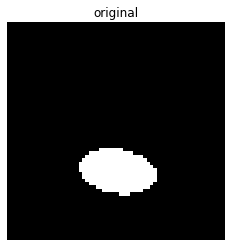

In [11]:
index = np.random.randint(0, len(dataset))
original = dataset[index].float()
plt.imshow(torch.sigmoid(original.detach()).view(64,64), cmap='Greys_r')
plt.axis('off')
plt.title('original')
plt.show()

In [12]:
index

449051

# Beta-VAE with beta=1

In [12]:
model_beta1 = torch.load("../trained_models/normal_dataset_bernoulli_fc_models/betavae_beta1_e50_n.dat")
model_beta1.cpu()
model_beta1.eval()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [13]:
# see Beta VAE notebook for computation
latent_gaussian_std_beta1 = [0.0514, 0.9818, 0.1145, 0.9793, 0.0236, 0.1030, 0.0533, 0.0572, 0.0401,
        0.9770]

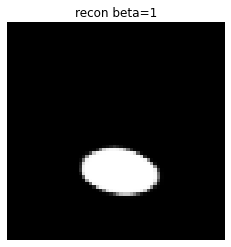

In [15]:
plot_recon(model_beta1, original, 'recon beta=1')

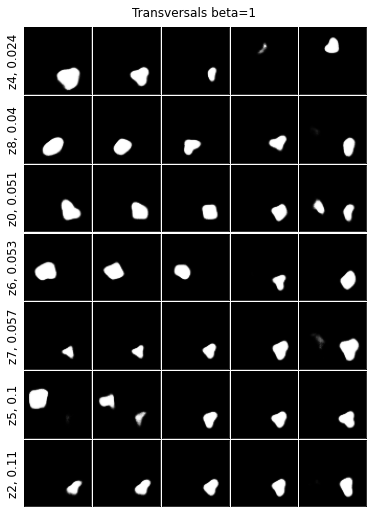

In [90]:
latent_transversal_plot(model_beta1, original, 
                        latent_gaussian_std_beta1, 
                        'Transversals beta=1', 
                        0.01, 0.03,
                        figsize=(5.1, 7))

# Beta-VAE with beta=4

In [63]:
model_beta4 = torch.load("../trained_models/normal_dataset_bernoulli_fc_models/betavae_beta4_e50_n.dat")
model_beta4.cpu()
model_beta4.eval()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [63]:
#Computation takes a lot of time, please use the next cell to assign directly
latent_gaussian_std_beta4 = compute_latent_gaussian_variance(model_beta4, dataset).tolist()

...........

In [72]:
latent_gaussian_std_beta4

[0.9948016405105591,
 0.9936812520027161,
 0.9945016503334045,
 0.2888352572917938,
 0.9963180422782898,
 0.9922326803207397,
 0.11154257506132126,
 0.04041251540184021,
 0.06364276260137558,
 0.18593019247055054]

In [36]:
latent_gaussian_std_beta4 = [0.9948016405105591,
                             0.9936812520027161,
                             0.9945016503334045,
                             0.2888352572917938,
                             0.9963180422782898,
                             0.9922326803207397,
                             0.11154257506132126,
                             0.04041251540184021,
                             0.06364276260137558,
                             0.18593019247055054]

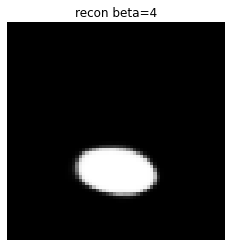

In [71]:
plot_recon(model_beta4, original, 'recon beta=4')

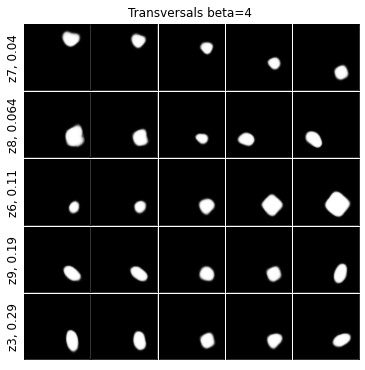

In [85]:
latent_transversal_plot(model_beta4, original, 
                        latent_gaussian_std_beta4, 
                        'Transversals beta=4', 
                        0.01, 0.03,
                        figsize=(5,5))

# Control-VAE with Cmax=20

In [13]:
model_c20 = torch.load("../trained_models/normal_dataset_bernoulli_fc_models/controlvae_epoch50_lr1e2_Cmax20_Cstep4.5_bern.dat")
model_c20.cpu()
model_c20.eval()

ControlVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [15]:
latent_gaussian_std_c20 = compute_latent_gaussian_variance(model_c20, dataset).tolist()

...........

In [16]:
latent_gaussian_std_c20

[0.9782128930091858,
 0.036687545478343964,
 0.09507922828197479,
 0.018568459898233414,
 0.9817420244216919,
 0.01688689924776554,
 0.9817491173744202,
 0.9792717695236206,
 0.9807136654853821,
 0.09681949764490128]

In [46]:
latent_gaussian_std_c20 = [0.9782128930091858,
                             0.036687545478343964,
                             0.09507922828197479,
                             0.018568459898233414,
                             0.9817420244216919,
                             0.01688689924776554,
                             0.9817491173744202,
                             0.9792717695236206,
                             0.9807136654853821,
                             0.09681949764490128]

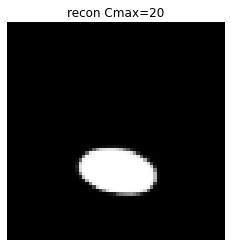

In [17]:
plot_recon(model_c20, original, 'recon Cmax=20')

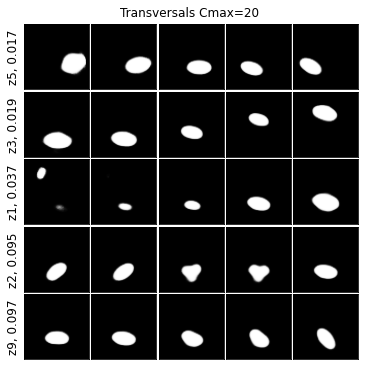

In [20]:
latent_transversal_plot(model_c20, original, latent_gaussian_std_c20, 
                        'Transversals Cmax=20', 
                        0.01, 0.04,
                        figsize=(5,5))

# Factor-VAE with gamma=5

In [55]:
model_gamma5 = torch.load("../trained_models/factorvae_epochs50_gamma5_lrvae0.01_lrd0.0001.dat")
model_gamma5.cpu()
model_gamma5.eval()

FactorVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [34]:
latent_gaussian_std_gamma5 = compute_latent_gaussian_variance(model_gamma5, dataset, factorvae=True).tolist()

...........

In [35]:
latent_gaussian_std_gamma5

[0.11379950493574142,
 0.988315224647522,
 0.06986241042613983,
 0.018830878660082817,
 0.98553466796875,
 0.9848303198814392,
 0.9871156215667725,
 0.04981806129217148,
 0.02033691294491291,
 0.981386661529541]

In [54]:
latent_gaussian_std_gamma5 = [0.11379950493574142,
 0.988315224647522,
 0.06986241042613983,
 0.018830878660082817,
 0.98553466796875,
 0.9848303198814392,
 0.9871156215667725,
 0.04981806129217148,
 0.02033691294491291,
 0.981386661529541]

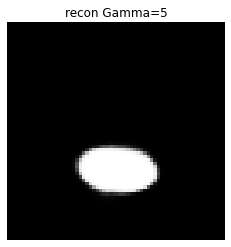

In [70]:
plot_recon(model_gamma5, original, 'recon Gamma=5', factorvae=True)

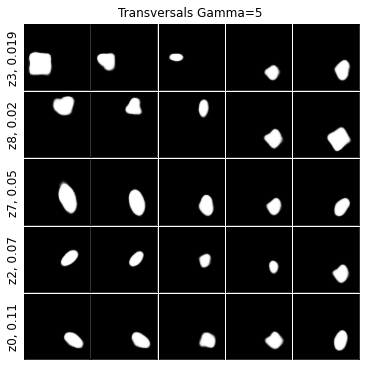

In [84]:
latent_transversal_plot(model_gamma5, original, latent_gaussian_std_gamma5, 
                        'Transversals Gamma=5', 
                        0.01, 0.03,
                        figsize=(5,5))

# Uniform noise Beta-VAE, beta=1

In [22]:
model_beta1_noise = torch.load(
    "../trained_models/uniform_noise_dataset_bernoulli_fc_models/betavae_beta1_e50_noise.dat")
model_beta1_noise.cpu()
model_beta1_noise.eval()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [25]:
latent_gaussian_std_beta1_noise = compute_latent_gaussian_variance(model_beta1_noise, dataset).tolist()

...........

In [26]:
latent_gaussian_std_beta1_noise

[0.09520209580659866,
 0.10456900298595428,
 0.9755767583847046,
 0.2608810067176819,
 0.25177863240242004,
 0.3371219336986542,
 0.15329314768314362,
 0.07698546350002289,
 0.9811497926712036,
 0.9841734766960144]

In [54]:
latent_gaussian_std_beta1_noise = [0.09520209580659866,
 0.10456900298595428,
 0.9755767583847046,
 0.2608810067176819,
 0.25177863240242004,
 0.3371219336986542,
 0.15329314768314362,
 0.07698546350002289,
 0.9811497926712036,
 0.9841734766960144]

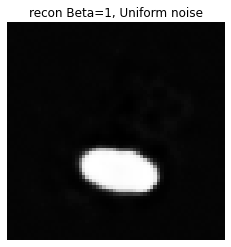

In [28]:
plot_recon(model_beta1_noise, original, 'recon Beta=1, Uniform noise')

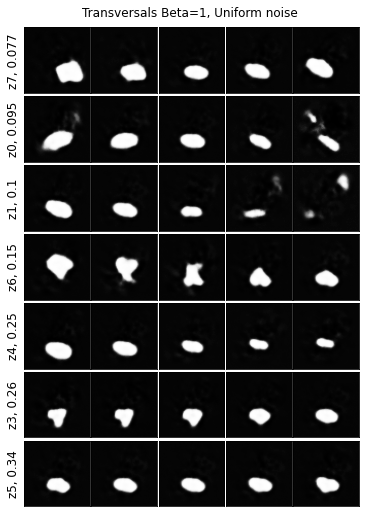

In [31]:
latent_transversal_plot(model_beta1_noise, original, latent_gaussian_std_beta1_noise, 
                        'Transversals Beta=1, Uniform noise', 
                        0.01, 0.05,
                        figsize=(5,7))

# Uniform noise Beta-VAE, beta=4

In [32]:
model_beta4_noise = torch.load(
    "../trained_models/uniform_noise_dataset_bernoulli_fc_models/betavae_beta4_e50_noise.dat")
model_beta4_noise.cpu()
model_beta4_noise.eval()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [33]:
latent_gaussian_std_beta4_noise = compute_latent_gaussian_variance(model_beta4_noise, dataset).tolist()

...........

In [34]:
latent_gaussian_std_beta4_noise

[1.0086936950683594,
 0.9970086812973022,
 0.9909389019012451,
 0.18837252259254456,
 0.3912440836429596,
 0.42843925952911377,
 1.0026527643203735,
 0.09521694481372833,
 0.9957735538482666,
 0.08328542858362198]

In [54]:
latent_gaussian_std_beta4_noise = [1.0086936950683594,
 0.9970086812973022,
 0.9909389019012451,
 0.18837252259254456,
 0.3912440836429596,
 0.42843925952911377,
 1.0026527643203735,
 0.09521694481372833,
 0.9957735538482666,
 0.08328542858362198]

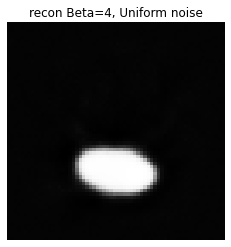

In [36]:
plot_recon(model_beta4_noise, original, 'recon Beta=4, Uniform noise')

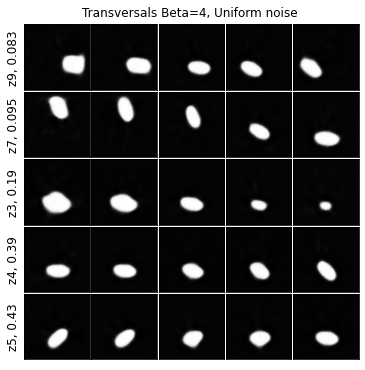

In [37]:
latent_transversal_plot(model_beta4_noise, original, latent_gaussian_std_beta4_noise, 
                        'Transversals Beta=4, Uniform noise', 
                        0.01, 0.03,
                        figsize=(5,5))

# Uniform noise Control-VAE, Cmax=20

In [38]:
model_c20_noise = torch.load(
    "../trained_models/uniform_noise_dataset_bernoulli_fc_models/controlvae_epoch50_lr1e2_Cmax20_Cstep4.5_bern_noisy.dat")
model_c20_noise.cpu()
model_c20_noise.eval()

ControlVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [39]:
latent_gaussian_std_c20_noise = compute_latent_gaussian_variance(model_c20_noise, dataset).tolist()

...........

In [40]:
latent_gaussian_std_c20_noise

[0.24724899232387543,
 0.23500803112983704,
 0.9908141493797302,
 0.062122393399477005,
 0.9944441914558411,
 0.984757661819458,
 0.06479214131832123,
 0.9915322065353394,
 0.9749281406402588,
 0.12030963599681854]

In [54]:
latent_gaussian_std_c20_noise = [0.24724899232387543,
 0.23500803112983704,
 0.9908141493797302,
 0.062122393399477005,
 0.9944441914558411,
 0.984757661819458,
 0.06479214131832123,
 0.9915322065353394,
 0.9749281406402588,
 0.12030963599681854]

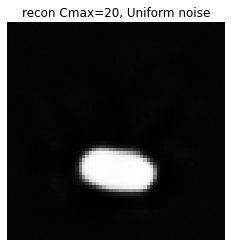

In [42]:
plot_recon(model_c20_noise, original, 'recon Cmax=20, Uniform noise')

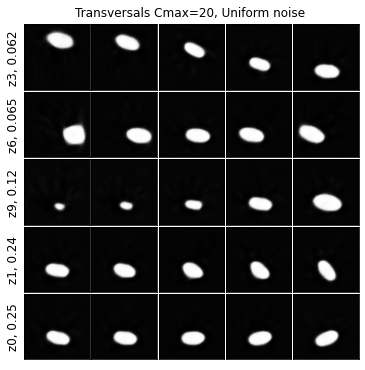

In [43]:
latent_transversal_plot(model_c20_noise, original, latent_gaussian_std_c20_noise, 
                        'Transversals Cmax=20, Uniform noise', 
                        0.01, 0.03,
                        figsize=(5,5))

# Uniform noise Factor-VAE, gamma=5

In [44]:
model_gamma5_noise = torch.load(
    "../trained_models/uniform_noise_dataset_bernoulli_fc_models/noisy_factorvae_epochs50_gamma5_lrvae0.01_lrd0.0001.dat")
model_gamma5_noise.cpu()
model_gamma5_noise.eval()

FactorVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [47]:
latent_gaussian_std_gamma5_noise = compute_latent_gaussian_variance(model_gamma5_noise, dataset, factorvae=True).tolist()

...........

In [48]:
latent_gaussian_std_gamma5_noise

[0.9970494508743286,
 0.9915425777435303,
 0.15485979616641998,
 0.9893260598182678,
 0.9964035749435425,
 0.989086389541626,
 0.05629746615886688,
 0.11787386238574982,
 0.05129130557179451,
 0.9910038709640503]

In [54]:
latent_gaussian_std_gamma5_noise = [0.9970494508743286,
 0.9915425777435303,
 0.15485979616641998,
 0.9893260598182678,
 0.9964035749435425,
 0.989086389541626,
 0.05629746615886688,
 0.11787386238574982,
 0.05129130557179451,
 0.9910038709640503]

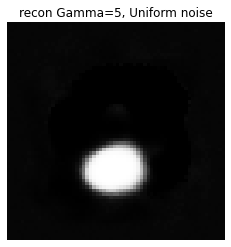

In [49]:
plot_recon(model_gamma5_noise, original, 'recon Gamma=5, Uniform noise', factorvae=True)

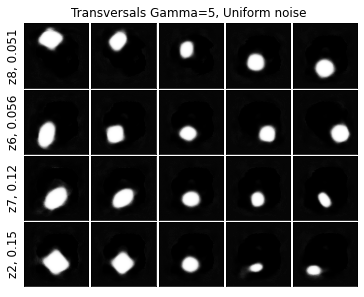

In [51]:
latent_transversal_plot(model_gamma5_noise, original, latent_gaussian_std_gamma5_noise, 
                        'Transversals Gamma=5, Uniform noise', 
                        0.01, 0.03,
                        figsize=(5,4))

# Generated noise Beta-VAE, beta=1

In [52]:
model_beta1_noise = torch.load(
    "../trained_models/generated_noise_bernoulli_fc_models/betavae_beta1_e50_custom_noise.dat")
model_beta1_noise.cpu()
model_beta1_noise.eval()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [53]:
latent_gaussian_std_beta1_noise = compute_latent_gaussian_variance(model_beta1_noise, dataset).tolist()

...........

In [54]:
latent_gaussian_std_beta1_noise

[0.9734631180763245,
 1.0040501356124878,
 0.9911653995513916,
 0.42263174057006836,
 0.23590610921382904,
 0.9707587361335754,
 0.23254676163196564,
 0.45022228360176086,
 1.0203949213027954,
 0.30493834614753723]

In [54]:
latent_gaussian_std_beta1_noise = [0.9734631180763245,
 1.0040501356124878,
 0.9911653995513916,
 0.42263174057006836,
 0.23590610921382904,
 0.9707587361335754,
 0.23254676163196564,
 0.45022228360176086,
 1.0203949213027954,
 0.30493834614753723]

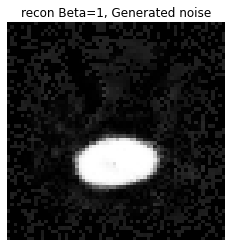

In [59]:
plot_recon(model_beta1_noise, original, 'recon Beta=1, Generated noise')

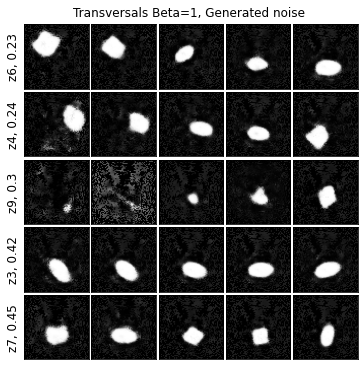

In [81]:
latent_transversal_plot(model_beta1_noise, original, latent_gaussian_std_beta1_noise, 
                        'Transversals Beta=1, Generated noise', 
                        0.01, 0.05,
                        figsize=(5,5))

# Generated noise Beta-VAE, beta=4

In [61]:
model_beta4_noise = torch.load(
    "../trained_models/generated_noise_bernoulli_fc_models/betavae_beta4_e50_custom_noise.dat")
model_beta4_noise.cpu()
model_beta4_noise.eval()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [62]:
latent_gaussian_std_beta4_noise = compute_latent_gaussian_variance(model_beta4_noise, dataset).tolist()

...........

In [63]:
latent_gaussian_std_beta4_noise

[0.9943584203720093,
 0.31797224283218384,
 1.0094224214553833,
 0.9974971413612366,
 0.3789847195148468,
 0.9957590103149414,
 0.5443004369735718,
 1.0165334939956665,
 0.8044562339782715,
 0.9818163514137268]

In [54]:
latent_gaussian_std_beta4_noise = [0.9943584203720093,
 0.31797224283218384,
 1.0094224214553833,
 0.9974971413612366,
 0.3789847195148468,
 0.9957590103149414,
 0.5443004369735718,
 1.0165334939956665,
 0.8044562339782715,
 0.9818163514137268]

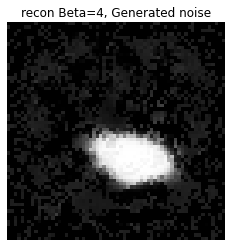

In [64]:
plot_recon(model_beta4_noise, original, 'recon Beta=4, Generated noise')

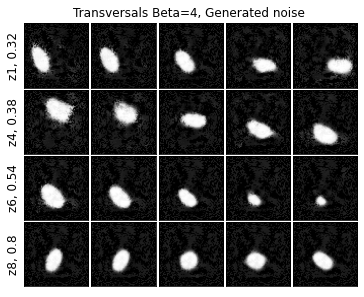

In [80]:
latent_transversal_plot(model_beta4_noise, original, latent_gaussian_std_beta4_noise, 
                        'Transversals Beta=4, Generated noise', 
                        0.01, 0.03,
                        figsize=(5,4))

# Generated noise Control-VAE, Cmax=20

In [66]:
model_c20_noise = torch.load(
    "../trained_models/generated_noise_bernoulli_fc_models/controlvae_epoch50_lr1e2_Cmax20_Cstep4.5_bern_noisy_gen.dat")
model_c20_noise.cpu()
model_c20_noise.eval()

ControlVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [67]:
latent_gaussian_std_c20_noise = compute_latent_gaussian_variance(model_c20_noise, dataset).tolist()

...........

In [68]:
latent_gaussian_std_c20_noise

[0.9622421860694885,
 0.96135014295578,
 0.9290330410003662,
 0.30676066875457764,
 0.2091628760099411,
 0.29493510723114014,
 0.9599039554595947,
 0.9530712366104126,
 0.9654397964477539,
 0.23322482407093048]

In [54]:
latent_gaussian_std_c20_noise = [0.9622421860694885,
 0.96135014295578,
 0.9290330410003662,
 0.30676066875457764,
 0.2091628760099411,
 0.29493510723114014,
 0.9599039554595947,
 0.9530712366104126,
 0.9654397964477539,
 0.23322482407093048]

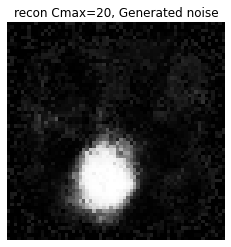

In [69]:
plot_recon(model_c20_noise, original, 'recon Cmax=20, Generated noise')

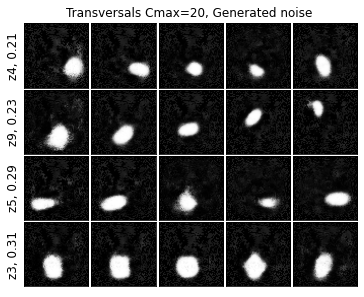

In [76]:
latent_transversal_plot(model_c20_noise, original, latent_gaussian_std_c20_noise, 
                        'Transversals Cmax=20, Generated noise', 
                        0.01, 0.03,
                        figsize=(5,4))

# Generated noise Factor-VAE, gamma=5

In [71]:
model_gamma5_noise = torch.load(
    "../trained_models/generated_noise_bernoulli_fc_models/gen_noise_factorvae_epochs50_gamma5_lrvae0.01_lrd0.0001.dat")
model_gamma5_noise.cpu()
model_gamma5_noise.eval()

FactorVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [72]:
latent_gaussian_std_gamma5_noise = compute_latent_gaussian_variance(model_gamma5_noise, dataset, factorvae=True).tolist()

...........

In [73]:
latent_gaussian_std_gamma5_noise

[0.2717350423336029,
 0.9888712763786316,
 0.9883654117584229,
 1.0329995155334473,
 0.9880750775337219,
 0.985844075679779,
 0.9409564733505249,
 0.30841612815856934,
 0.240448459982872,
 0.2703232169151306]

In [54]:
latent_gaussian_std_gamma5_noise = [0.2717350423336029,
 0.9888712763786316,
 0.9883654117584229,
 1.0329995155334473,
 0.9880750775337219,
 0.985844075679779,
 0.9409564733505249,
 0.30841612815856934,
 0.240448459982872,
 0.2703232169151306]

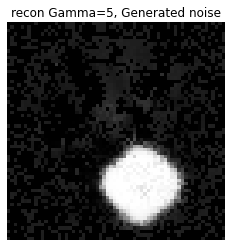

In [74]:
plot_recon(model_gamma5_noise, original, 'recon Gamma=5, Generated noise', factorvae=True)

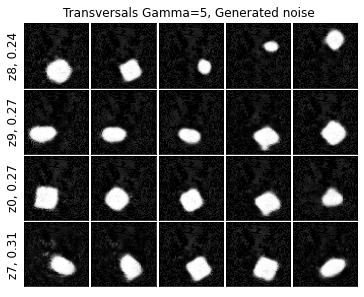

In [75]:
latent_transversal_plot(model_gamma5_noise, original, latent_gaussian_std_gamma5_noise, 
                        'Transversals Gamma=5, Generated noise', 
                        0.01, 0.03,
                        figsize=(5,4))

In [79]:
models = [
    model_beta1,
    model_beta4,
    model_c10,
    model_gamma5,
]
titles = [
    'beta1',
    'beta4',
    'c10',
    'gamma5'
]

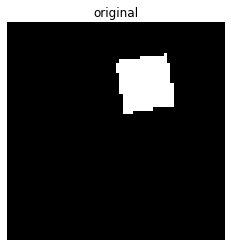

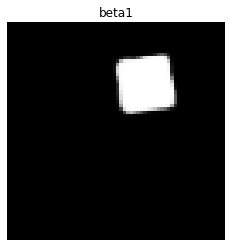

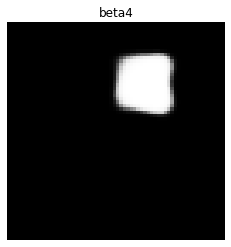

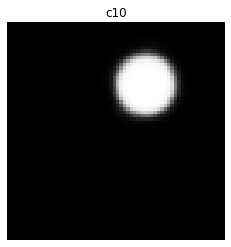

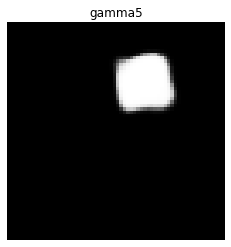

In [93]:
index = np.random.randint(0, len(dataset))
original = dataset[index].float()
plt.imshow(torch.sigmoid(original.detach()).view(64,64), cmap='Greys_r')
plt.axis('off')
plt.title('original')
plt.show()

for i, model in enumerate(models):
    if i != 3:
        plot_recon(model, original, titles[i])
    else:
        plot_recon(model, original, titles[i], factorvae=True)

In [94]:
test_loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [119]:
def compute_recon_loss_alldata(model, loader, factorvae=False):
    with torch.no_grad():
        losses = []
        for data in loader:
            data = data.float()
            if not factorvae:
                recon, mu, logvar = model(data)
            else:
                recon, mu, logvar, _ = model(data)
            recon_loss = compute_reconstruction_loss(recon, data.view(recon.size()), 'bernoulli', data.size(0))
            losses.append(recon_loss.item())
    return np.mean(losses)

In [117]:
compute_recon_loss_alldata(model_beta1, test_loader)

31.536590099748636

In [118]:
compute_recon_loss_alldata(model_beta4, test_loader)

58.44072954820262

In [110]:
compute_recon_loss_alldata(model_c10, test_loader)

93.58285383515887

In [112]:
compute_recon_loss_alldata(model_gamma5, test_loader, True)

45.86232941978508

In [113]:
test_control_vae(model_c10, test_loader, 'bernoulli')

28.308221789532237

In [115]:
test_beta_vae(model_beta4, test_loader, 4, 'bernoulli')

58.47517977439695

In [120]:
compute_recon_loss_alldata(model_c10, test_loader)

28.30315280780196